# Hough transform

We'll use Hough transform to count sticks and red blood cells.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, feature
from skimage.transform import hough_line, hough_line_peaks
import cv2

## Hough Lines

We start counting sticks usin `hough_line` method from `skimage` library. We only miss one stick.

Numero de linhas encontradas: 20


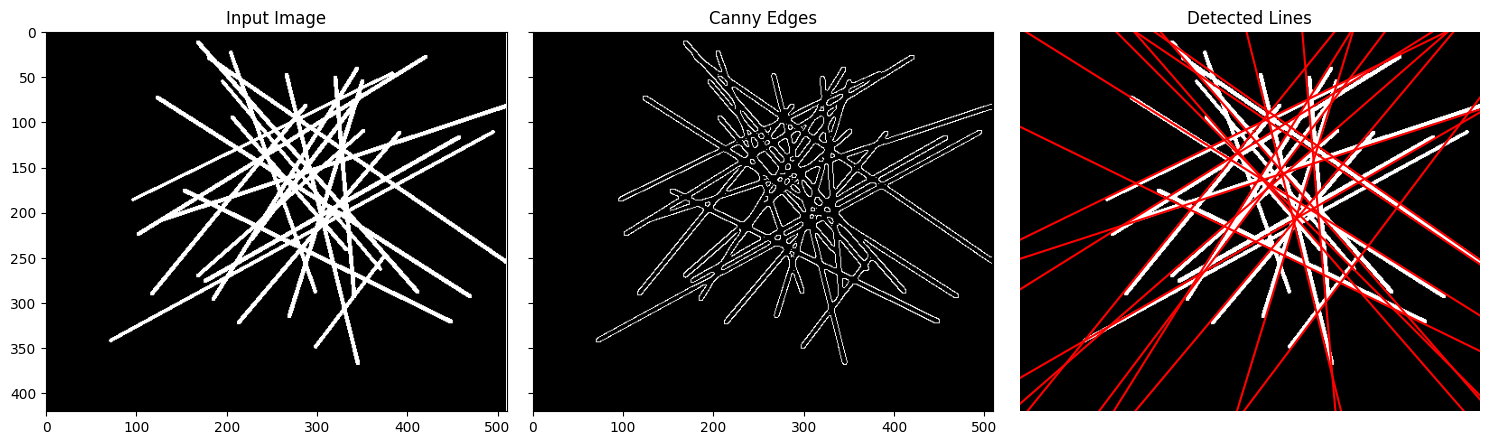

In [6]:
image_path = 'img/jogo-dos-palitos.png'
image = io.imread(image_path)
gray_image = color.rgb2gray(image)

gray_image = np.where(gray_image < 0.95, 1.0, 0.0)

edges = feature.canny(gray_image, sigma=2.0)
h, theta, d = hough_line(edges)

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[0].set_title('Input Image')

ax[1].imshow(edges, cmap=plt.cm.gray)
ax[1].set_title('Canny Edges')

ax[2].imshow(gray_image, cmap=plt.cm.gray)
row1, col1 = gray_image.shape

count = 0
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    count+=1
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, col1), (y0, y1), '-r')

print('Numero de linhas encontradas:',count)

ax[2].set_xlim((0, col1))
ax[2].set_ylim((row1, 0))
ax[2].set_axis_off()
ax[2].set_title('Detected Lines')

plt.tight_layout()
plt.show()

Next, we'll use `HoughCircles` from `OpenCV` to cound red blood cells

Número de hemácias detectadas: 189


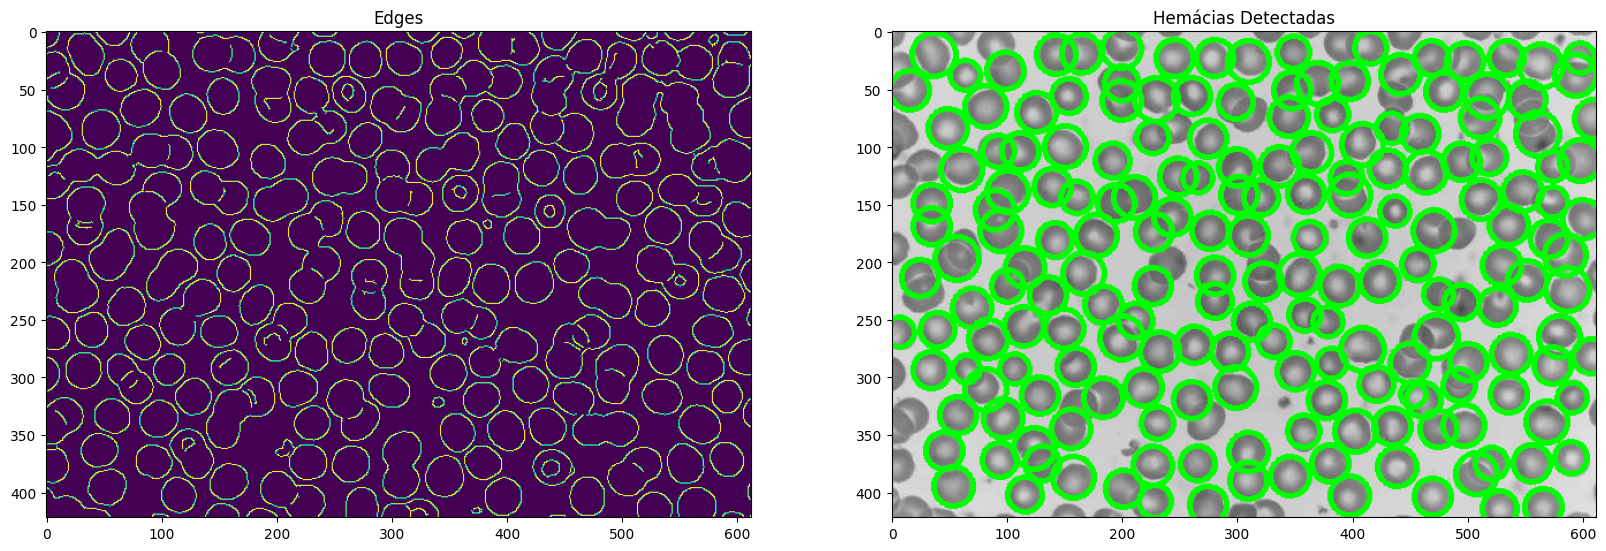

In [7]:

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 20))

image = cv2.imread('img/Hemacias.jpg', cv2.IMREAD_GRAYSCALE)
blurred_image = cv2.medianBlur(image, 5)
edges = cv2.Canny(blurred_image, 100, 200)

ax[0].imshow(edges.astype(float))
ax[0].set_title('Edges')

circles = cv2.HoughCircles(
    edges,
    cv2.HOUGH_GRADIENT, 
    dp=1.1, 
    minDist=10,
    param1=50, 
    param2=20, 
    minRadius=10, 
    maxRadius=20
)

circles = np.round(circles[0, :]).astype("int")
print(f'Número de hemácias detectadas: {len(circles)}')

output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for (x, y, r) in circles:
    cv2.circle(output, (x, y), r, (0, 255, 0), 4)

ax[1].imshow(output)
ax[1].set_title('Hemácias Detectadas')

plt.show()


After adjusting and testing various parameter combinations, 189 red blood cells were found in the image. The algorithm has difficulty in finding circles with centers that are very close together and also fails at the edges of the image since the circles are not complete.

## Sinogram of the Hough Transform

Finally, we plot the Sinogram of the Hough Transform:

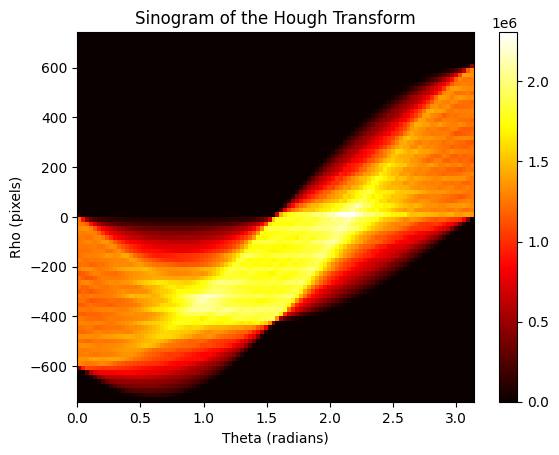

In [8]:
def hough_transform_lines(image, theta_res=100, rho_res=82):
    
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    
    height, width = img.shape
    
    max_rho = int(np.hypot(height, width))
    rhos = np.linspace(-max_rho, max_rho, rho_res)
    thetas = np.linspace(0, np.pi, theta_res)
    accumulator = np.zeros((rho_res, theta_res), dtype=np.float32)
    
    y_idxs, x_idxs = np.nonzero(img)
    
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        intensity = img[y, x]
        
        for t_idx in range(len(thetas)):
            theta = thetas[t_idx]
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.argmin(np.abs(rhos - rho))
            accumulator[rho_idx, t_idx] += intensity
    
    return accumulator, thetas, rhos

accumulator, thetas, rhos = hough_transform_lines('img/Hemacias.jpg')

plt.imshow(accumulator, extent=[thetas[0], thetas[-1], rhos[0], rhos[-1]], aspect='auto', cmap='hot')
plt.title('Sinogram of the Hough Transform')
plt.xlabel('Theta (radians)')
plt.ylabel('Rho (pixels)')
plt.colorbar()
plt.show()